# Plant Disease Detection Code

## Import Dependencies

In [78]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [79]:
# Torch
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

<IPython.core.display.Javascript object>

In [80]:
# A simple extension for Jupyter Notebook and Jupyter Lab to beautify Python code automatically using Black.
%load_ext nb_black


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Import Dataset

Transforms are used for Data Augmentation like cropping the image, resize the image, convert the image to tensor, rotate the image, and many more. Transforms work as a filter for all images. We are using the following code to transform the images.

In [81]:
transform = transforms.Compose(
    [transforms.Resize(255), 
     transforms.RandomCrop(224,10),
     transforms.ToTensor()]
)


<IPython.core.display.Javascript object>

In [82]:
dataset = datasets.ImageFolder(
    "Plant_leave_diseases_dataset_with_augmentation", transform=transform)


<IPython.core.display.Javascript object>

In [83]:
dataset

Dataset ImageFolder
    Number of datapoints: 61468
    Root location: Plant_leave_diseases_dataset_with_augmentation
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               RandomCrop(size=(224, 224), padding=10)
               ToTensor()
           )

<IPython.core.display.Javascript object>

## Split into Train and Test


In [84]:
indices = list(range(len(dataset)))
split = int(np.floor(0.85 * len(dataset)))  # train_size
validation = int(np.floor(0.70 * split))  # validation
#print(0, validation, split, len(dataset))
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")


length of train size :36572
length of validation size :15675
length of test size :24896


<IPython.core.display.Javascript object>

Like this, we use ~60% for training and ~40% for testing.
About validation data :

If you want to build a solid model you have to follow that specific protocol of splitting your data into three sets: One for training, one for validation and one for final evaluation, which is the test set.

The idea is that you train on your training data and tune your model with the results of metrics (accuracy, loss etc) that you get from your validation set.

Your model doesn't "see" your validation set and isn't in any way trained on it, but you as the architect and master of the hyperparameters tune the model according to this data. Therefore it indirectly influences your model because it directly influences your design decisions. You nudge your model to work well with the validation data and that can possibly bring in a tilt.

Exactly that is the reason you only evaluate your model's final score on data that neither your model nor you yourself has used – and that is the third chunk of data, your test set.

Only this procedure makes sure you get an unaffected view of your models quality and ability to generalize what is has learned on totally unseen data.

In [85]:
# randomize the choice of test, train and validation images
np.random.shuffle(indices)


<IPython.core.display.Javascript object>

In [86]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

<IPython.core.display.Javascript object>

Here in the above code we first getting indices and then split the data into train , test and validation data. Total 36584 for train , 15679 for validaiton and remaining images for testing.

In [87]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)


<IPython.core.display.Javascript object>

SubsetRandomSampler is used to sample our data. Here we are creating an object of SubsetRandomSampler Object and later we will use this sampler in train data loader and test data loader.

In [88]:
targets_size = len(dataset.class_to_idx)

<IPython.core.display.Javascript object>

## Model


Convolution Aithmetic Equation : (W - F + 2P) / S + 1
W = Input Size
F = Filter Size
P = Padding Size
S = Stride

In [89]:
class CropDetectCNN(nn.Module):
    # initialize the class and the parameters
    def __init__(self):
        super(CropDetectCNN, self).__init__()

        # convolutional layer 1 & max pool layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.MaxPool2d(kernel_size=2))

        # convolutional layer 2 & max pool layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
            nn.MaxPool2d(kernel_size=2))

        #Fully connected layer
        self.fc = nn.Linear(32*28*28, 39)
        
        

    # Feed forward the network
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


model = CropDetectCNN()
print(model)


CropDetectCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=25088, out_features=39, bias=True)
)


<IPython.core.display.Javascript object>

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


<IPython.core.display.Javascript object>

In [91]:
#model = CNN(targets_size)


<IPython.core.display.Javascript object>

In [92]:
model.to(device)


CropDetectCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=25088, out_features=39, bias=True)
)

<IPython.core.display.Javascript object>

In [93]:
from torchsummary import summary

summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             448
         MaxPool2d-2         [-1, 16, 111, 111]               0
            Conv2d-3           [-1, 32, 56, 56]           4,640
         MaxPool2d-4           [-1, 32, 28, 28]               0
            Linear-5                   [-1, 39]         978,471
Total params: 983,559
Trainable params: 983,559
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 8.48
Params size (MB): 3.75
Estimated Total Size (MB): 12.80
----------------------------------------------------------------


<IPython.core.display.Javascript object>

In [94]:
criterion = nn.CrossEntropyLoss()  # this include softmax => No + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())


<IPython.core.display.Javascript object>

## Batch Gradient Descent

In [95]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    
    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()
            
        
        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:
            
            model.eval()
            
            with torch.no_grad():

                inputs, targets = inputs.to(device), targets.to(device)

                output = model(inputs)

                loss = criterion(output, targets)

                validation_loss.append(loss.item())  # torch to numpy world
        
        
        
        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss: {train_loss:.3f} Validation_loss: {validation_loss:.3f} Duration: {dt}"
        )

    return train_losses, validation_losses
 #accuracy += torch.mean(equals.type(torch.FloatTensor))


<IPython.core.display.Javascript object>

In [96]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

dataiter = iter(train_loader)
images, classes = dataiter.next()
print(type(images))
print(images.shape)
print(classes.shape)


<class 'torch.Tensor'>
torch.Size([8, 3, 224, 224])
torch.Size([8])


<IPython.core.display.Javascript object>

In [97]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 4
)



Epoch : 1/4 Train_loss: 1.539 Validation_loss: 1.241 Duration: 0:14:50.920072
Epoch : 2/4 Train_loss: 1.060 Validation_loss: 0.936 Duration: 0:16:57.253714
Epoch : 3/4 Train_loss: 0.913 Validation_loss: 0.943 Duration: 0:17:21.649750
Epoch : 4/4 Train_loss: 0.806 Validation_loss: 0.871 Duration: 0:17:35.275104


<IPython.core.display.Javascript object>

## Save the model

In [98]:
torch.save(model.state_dict() , 'plant_disease_model_1.pt')

<IPython.core.display.Javascript object>

## Load the model

In [99]:
targets_size = 39
model = CropDetectCNN()
model.load_state_dict(torch.load("plant_disease_model_1.pt"))
model.eval()


CropDetectCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=25088, out_features=39, bias=True)
)

<IPython.core.display.Javascript object>

In [100]:
%matplotlib notebook
%matplotlib inline


<IPython.core.display.Javascript object>

## Plot the loss

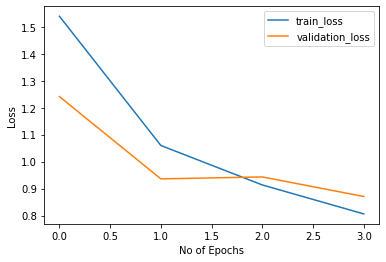

<IPython.core.display.Javascript object>

In [101]:
plt.plot(train_losses, label='train_loss')
plt.plot(validation_losses, label='validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Accuracy

In [102]:
def accuracy(loader):
    n_correct = 0
    n_total = 0
    model.eval()
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc


train_acc = accuracy(train_loader)
validation_acc = accuracy(validation_loader)
test_acc = accuracy(test_loader)

print(
    f"Train Accuracy : {train_acc}\nValidation Accuracy : {validation_acc}\nTest Accuracy : {test_acc}"
)


Train Accuracy : 0.7635622880892486
Validation Accuracy : 0.7518341307814992
Test Accuracy : 0.7536058995770524


<IPython.core.display.Javascript object>

## Single Image prediction

In [ ]:
model.class_to_idx = dataset.class_to_idx
model.class_to_idx.items()

# transform_index_to_disease = dataset.class_to_idx


In [ ]:
transform_index_to_disease = dict(
    [(value, key) for key, value in model.class_to_idx.items()]
)  # reverse the index
transform_index_to_disease.items()


In [105]:
from PIL import Image
import torchvision.transforms.functional as TF

def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data)
    #top_p, top_cl = ps.topk(5, dim=1)
    
    output = output.detach().numpy()
    
    index = np.argmax(output)
    
    
    print("Original : ", image_path.split("/")[-2])
    
    print(f"Prediction of our model: ", transform_index_to_disease[index])
    
    return image, output

    




<IPython.core.display.Javascript object>

In [ ]:
from scipy.special import softmax

image, pred = single_prediction("")


probabilities = softmax(pred)

print(probabilities)

probabilities.sum()

In [115]:
from PIL import Image
import numpy as np
# Plot the image

def imshow(image):
    fig, ax = plt.subplots()

    # convert the shape from (3, 256, 256) to (256, 256, 3)
    image = image.transpose(0, 1, 2)
    ax.imshow(image)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def process_image(image_path):

    test_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.ToTensor()])
    im = Image.open(image_path)
    imshow(np.array(im))
    im = test_transform(im)
    
    return im




<IPython.core.display.Javascript object>

In [116]:
def predict(image, model):
    # we have to process the image as we did while training the others
    image = process_image(image)

    #returns a new tensor with a given dimension
    image_input = image.unsqueeze(0)

    # Convert the image to either gpu|cpu
    image_input.to(device)

    # Pass the image through the model
    outputs = model(image_input)
    
    # Softmax on our output -> Transforming prediction scores into probabilities
    m = nn.Softmax(dim=1)
    proba = m(outputs)
        
    # return the top 5 most predicted classes
    top_p, top_cls = proba.topk(5, dim=1)
        
    # convert to numpy, then to list
    top_cls = top_cls.detach().numpy().tolist()[0]

    # covert indices to classes
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}

    top_cls = [idx_to_class[top_class] for top_class in top_cls]

    return top_p, top_cls


<IPython.core.display.Javascript object>

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_solution(image_path, ps, classes):
    
    fig = plt.figure(figsize=(6, 10))
    image = process_image(image_path)
    plt.subplot(2, 1, 2)
    image
    sns.barplot(x=ps, y=classes, color=sns.color_palette()[2])
    fig.show()

<IPython.core.display.Javascript object>

In [ ]:
from collections import Counter
image = ""

results = []
for i in range(100):
    ps, classes = predict(image, model)
    ps = ps.detach().numpy().tolist()[0]
    results.append(classes[0])


print(f"Results for 100 predictions of a Grape___Black_rot: ",
      Counter(results))


In [ ]:
from collections import Counter
image = ""

results=[]
# for i in range(100):
#     ps, classes = predict(image, model)
#     ps = ps.detach().numpy().tolist()[0]
#     results.append(classes[0])
ps, classes = predict(image, model)
ps = ps.detach().numpy().tolist()[0]

plot_solution(image, ps, classes)

#print(f"Results for 1 predictions of a Black rot disease on an apple leaf: ", Counter(results))




In [ ]:
image = ""
ps, classes = predict(image, model)
ps = ps.detach().numpy().tolist()[0]

print(ps)
print(classes)

plot_solution(image, ps, classes)


In [ ]:
image = ""
ps, classes = predict(image, model)
ps = ps.detach().numpy().tolist()[0]

print(ps)
print(classes)

plot_solution(image, ps, classes)
